# Subset seeding locations of the Global Model inside the Caribbean regions

Uniform coastal distribution based on Jambeck et al. 2015

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import urllib.request
import skimage.io as io
import copy
import os
from os.path import join
from datetime import datetime
import scipy as sc
from scipy import stats
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import generic_filter
import shapely
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean
import numba as nb

In [2]:
# parameters
mpw_to_ocean_ratio = 0.25   # Jambeck and Lebreton
light_particle_ratio = 0.4  # Lebreton, meaning that 60% sink on release

In [3]:
caribbean_countries = [ # countries
    'Antigua and Barbuda', 'Bahamas', 'Barbados',
    'Cuba', 'Dominica', 'Dominican Republic',
    'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Trinidad and Tobago',
    # dependant teritory
    'Anguilla', 'Aruba',
    'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands', 'Cayman Islands',
    'Curaçao', 'Guadeloupe', 'Martinique',
    'Montserrat', 'Puerto Rico', 'Saint-Barthélemy',
    'Saint-Martin', 'Sint Maarten',
    'Turks and Caicos Islands', 'Virgin Islands, U.S.',
    # other countries
    'Mexico', 'United States', 'Venezuela', 'Belize', 'Colombia',
    'Costa Rica', 'Guatemala', 'Guyana', 'Honduras', 'Nicaragua', 'Panama',
    'Suriname']

# Uniform distribution using Jambeck et al. 2015 ([2010](https://ourworldindata.org/grapher/mismanaged-plastic-waste), [2025](https://ourworldindata.org/grapher/mismanaged-plastic-waste-in-2025))

1. they quantified plastic waste generated by coastal populations (those within *50 kilometres of a coastline*) — this represents plastic waste with the potential to be transported to the coast. Plastic waste generated further inland is unlikely to travel this distance.

2. they corrected this figure for the quantity of plastic waste that is mismanaged. Mismanaged waste is the sum of inadequately managed waste (that which is not formally managed such as disposal in dumps or open, uncontrolled landfills which could leak to the surrounding environment) and littered waste. Mismanaged waste within coastal populations has strong potential to eventually enter the ocean either through transport by wind or tides, or through waterways such as rivers or wastewater.

From the tons of MPW, **25%** is expected to end up in the Ocean.

In [4]:
raw = pd.read_csv('../data/raw/jambeck-2015/mismanaged-plastic-waste.csv', delimiter=',')
raw = raw.rename(columns={'Entity': 'Country'})
raw.drop(columns=['Code'], inplace=True) # drop columns we won't need

In [5]:
raw.head()

,Country,Year,Total mismanaged plastic waste in 2010
0,Albania,2010,29705
1,Algeria,2010,520555
2,Angola,2010,62528
3,Anguilla,2010,52
4,Antigua and Barbuda,2010,1253


In [6]:
mpw = np.zeros(len(caribbean_countries))

for i, c in enumerate(caribbean_countries):
    j = np.where(raw.Country == c)[0]
    if len(j):
        mpw[i] = raw.iloc[j]['Total mismanaged plastic waste in 2010']
    else:
        print(f'No data {c} (index={i})')

No data Bonaire, Sint Eustatius and Saba (index=15)
No data Curaçao (index=18)
No data Saint-Barthélemy (index=23)
No data Saint-Martin (index=24)
No data Sint Maarten (index=25)
No data Virgin Islands, U.S. (index=27)


## Data for missing countries
- some countries are not found because they are recorded with a different name
- in the case of missing data, we estimate the mismanaged plastic wasted from nearby country and scale by the population ratio 

In [7]:
# Netherlands Antilles = Bonaire, Sint Eustatius and Saba
j = np.where(raw.Country.str.contains('Netherlands Antilles'))[0]
mpw[15] = raw.iloc[j]['Total mismanaged plastic waste in 2010']

# Curacao
j = np.where(raw.Country.str.contains('Curacao'))[0]
mpw[18] = raw.iloc[j]['Total mismanaged plastic waste in 2010']

# Saint-Barthélemy Population 9,961
# scale with Anguilla Population 14,731 (2018)
j = np.where(raw.Country.str.contains('Anguilla'))[0]
mpw[23] = raw.iloc[j]['Total mismanaged plastic waste in 2010'] * 9961/14731

# Saint-Martin Population 73,666 (2019)
j = np.where(raw.Country.str.contains('Sint Maarten'))[0]
mpw[24] = raw.iloc[j]['Total mismanaged plastic waste in 2010'] * 73666/40812

# Sint Maarten (Dutch part) Population 40,812 (2020)
j = np.where(raw.Country.str.contains('Sint Maarten'))[0]
mpw[25] = raw.iloc[j]['Total mismanaged plastic waste in 2010']

# Virgin Islands Population 106,290 (2020)
# British Virgin Island Population 30,237 (2020)
# Scale by population with the British Virgin Island
mpw[27] = raw.iloc[18]['Total mismanaged plastic waste in 2010'] * 106290/30237

# Geopandas with the shapefile of the countries and MPW estimates from Jambeck et al

In [8]:
df = gpd.read_file('../data/raw/gadm36/gadm36_0.shp')
df = df.rename(columns={'NAME_0': 'country'})
df.drop(columns=['GID_0'], inplace=True)

row_caribbean = [np.where(df.country == c)[0][0] for c in caribbean_countries if len(np.where(df.country == c)[0])]
df = df.loc[row_caribbean].reset_index(drop=True)

In [9]:
df['mpw [ton/year]'] = mpw

In [10]:
with xr.open_dataset('../data/process/country_GLBv0.08.nc') as ds:
    df['uniform mpw [ton/year/gridcell]'] =  df['mpw [ton/year]'] / ds.country_coastlines

In [11]:
df.head()

,country,geometry,mpw [ton/year],uniform mpw [ton/year/gridcell]
0,Antigua and Barbuda,"MULTIPOLYGON (((-62.34514 16.94514, -62.34514 ...",1253.0,59.666667
1,Bahamas,"MULTIPOLYGON (((-72.99986 20.99986, -73.00014 ...",1333.0,2.192434
2,Barbados,"POLYGON ((-59.47375 13.07705, -59.47375 13.076...",3483.0,248.785714
3,Cuba,"MULTIPOLYGON (((-77.27348 19.90014, -77.27348 ...",90630.0,117.093023
4,Dominica,"POLYGON ((-61.33379 15.21208, -61.33458 15.212...",783.0,48.937500


In [12]:
# model grid
ds = xr.open_dataset('../data/process/land_GLBv0.08.nc')
plon = ds.plon.values # center of cell
plat = ds.plat.values
gplon, gplat = np.meshgrid(plon, plat)
qlon = ds.qlon.values # corner of cell
qlat = ds.qlat.values 
ds.close()

In [13]:
# binning the coastlines first brings the number of points down to ~9000
# friom the initial 4322212 coordinates of the 40 countries in the region
paths_list = []

for i in range(0, len(df)):
    pi_i = np.empty(0, dtype='int'); pj_i = np.empty_like(pi_i)
    geos = df.iloc[i].geometry
    if type(geos) == shapely.geometry.multipolygon.MultiPolygon:
        for j, g in enumerate(geos):
            x,y = g.exterior.coords.xy
            
            ret_c = stats.binned_statistic_2d(x, y, 
                              np.ones_like(x), 
                              statistic='count', 
                              bins=[qlon, qlat])
            
            pi, pj = np.where(ret_c.statistic.T > 0)
            pi_i = np.hstack((pi_i, pi))
            pj_i = np.hstack((pj_i, pj))
            
    else:
        x,y = geos.exterior.coords.xy
        
        ret_c = stats.binned_statistic_2d(x, y, 
                              np.ones_like(x), 
                              statistic='count', 
                              bins=[qlon, qlat])
        
        pi, pj = np.where(ret_c.statistic.T > 0)
        pi_i = np.hstack((pi_i, pi))
        pj_i = np.hstack((pj_i, pj))
    
    # remove dupplicates
    pij_1d = np.ravel_multi_index((pi_i, pj_i), (len(qlat), len(qlon)))
    pi_i, pj_i = np.unravel_index(np.unique(pij_1d), (len(qlat), len(qlon)))
    
    coords = np.column_stack((qlon[pj_i],qlat[pi_i]))
    paths_list.append(coords)

# To identify the model grid to generate random particles, we performed the next three steps per country:
- binned the shapefile coastlines into the model grid
- restric to the Atlantic and Caribbean region
- move to the 2nd closest ocean box

In [14]:
# model grid
ds = xr.open_dataset('../data/process/land_GLBv0.08.nc')
plon = ds.plon.values # center of cell
plat = ds.plat.values
land = ds.land.values
land2x = generic_filter(land, lambda x: np.max(x), size=3, mode='constant')
gplon, gplat = np.meshgrid(plon, plat)
qlon = ds.qlon.values # corner of cell
qlat = ds.qlat.values 
ds.close()

In [15]:
# binning the coastlines first brings the number of points down to ~9000
# friom the initial 4322212 coordinates of the 40 countries in the region
paths_list = []

for i in range(0, len(df)):
    pi_i = np.empty(0, dtype='int'); pj_i = np.empty_like(pi_i)
    geos = df.iloc[i].geometry
    if type(geos) == shapely.geometry.multipolygon.MultiPolygon:
        for j, g in enumerate(geos):
            x,y = g.exterior.coords.xy
            
            ret_c = stats.binned_statistic_2d(x, y, 
                              np.ones_like(x), 
                              statistic='count', 
                              bins=[qlon, qlat])
            
            pi, pj = np.where(ret_c.statistic.T > 0)
            pi_i = np.hstack((pi_i, pi))
            pj_i = np.hstack((pj_i, pj))
            
    else:
        x,y = geos.exterior.coords.xy
        
        ret_c = stats.binned_statistic_2d(x, y, 
                              np.ones_like(x), 
                              statistic='count', 
                              bins=[qlon, qlat])
        
        pi, pj = np.where(ret_c.statistic.T > 0)
        pi_i = np.hstack((pi_i, pi))
        pj_i = np.hstack((pj_i, pj))
    
    # remove dupplicates
    pij_1d = np.ravel_multi_index((pi_i, pj_i), (len(plat), len(plon)))
    pi_i, pj_i = np.unravel_index(np.unique(pij_1d), (len(plat), len(plon)))
    
    paths_list.append(np.column_stack((pj_i,pi_i)))
    
# remove border on land from the path list
for c in range(0, len(caribbean_countries)):
    k = 0
    keep = np.ones(len(paths_list[c]), dtype='bool')
    for j,i in paths_list[c]:
        if np.all(land[i-1:i+2, j-1:j+2]) == True: # all boxes around are land
            keep[k] = False
        k += 1
    paths_list[c] = paths_list[c][keep]

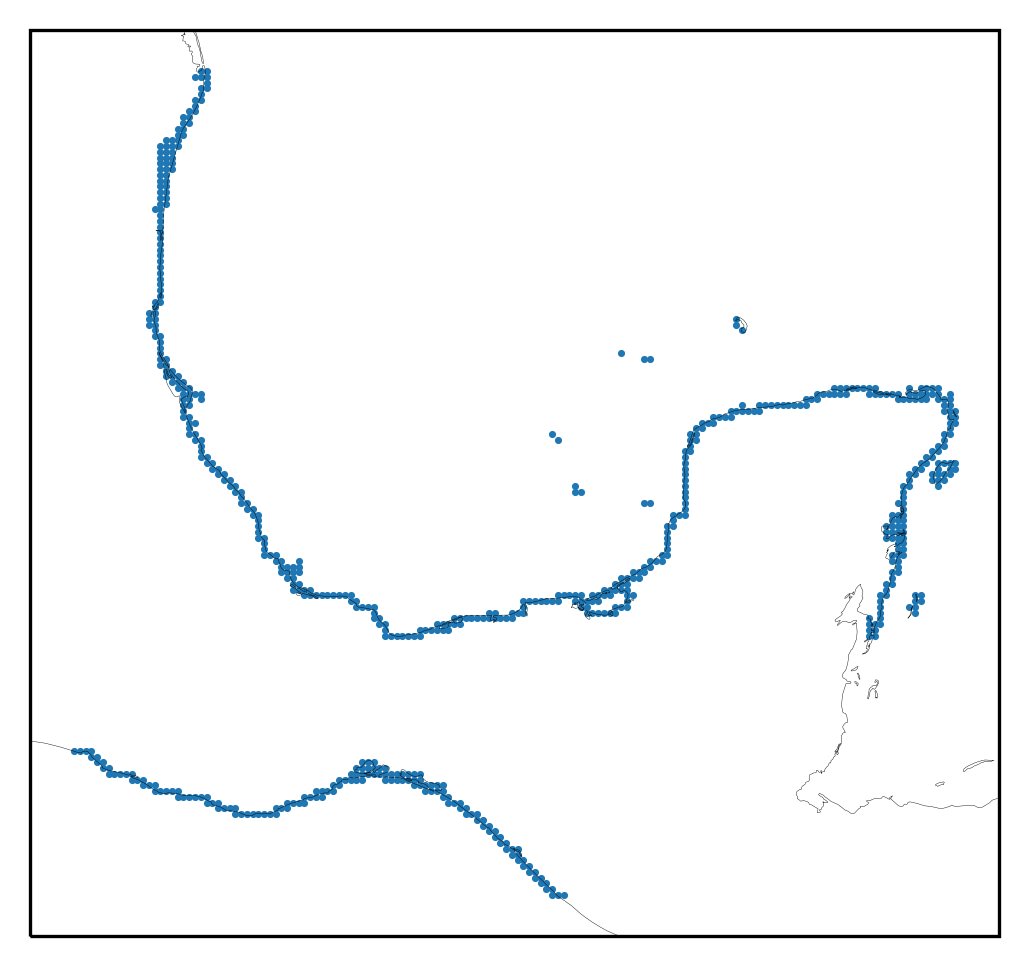

In [16]:
# coastal mpw from rivers
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

i = 28
ax.scatter(plon[paths_list[i][:,0]], plat[paths_list[i][:,1]], s=0.5, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

In [17]:
## Remove particles on the pacific side
xc = np.array([-51.6, -76.8, -78, -79.3, -81, -82.7, -87.3, -98.5, -98.5, -66.7, -51.6, -51.6])
yc = np.array([3.5, 7, 8.6, 9.2, 8.2, 8.8, 14.8, 19.0, 31.0, 31.0, 31.0, 3.9])
p = path.Path(np.vstack((xc, yc)).T)

region_paths_list = copy.deepcopy(paths_list)

# remove border on land from the path list
for c in range(0, len(caribbean_countries)):
    keep = np.ones(len(region_paths_list[c]), dtype='bool')
    k = 0
    for i,j in paths_list[c]:
        keep[k] = p.contains_points(np.column_stack((plon[i], plat[j])))[0]
        k += 1
        
    region_paths_list[c] = paths_list[c][keep]

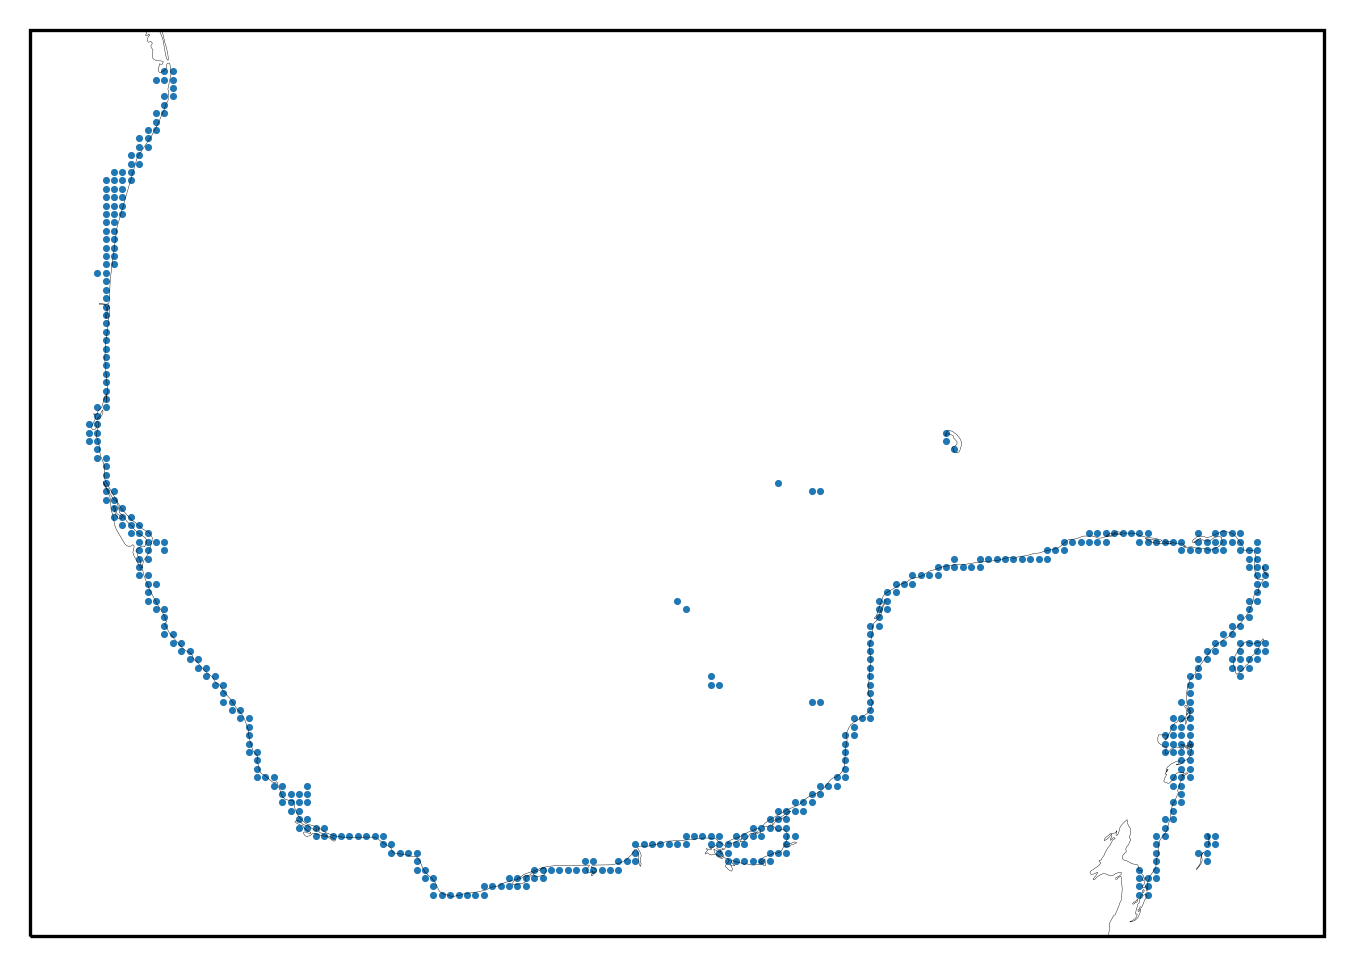

In [18]:
# coastal mpw from rivers
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

i = 28
ax.scatter(plon[region_paths_list[i][:,0]], plat[region_paths_list[i][:,1]], s=0.5, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

# Move the plastic to the closest ocean bins (2 grid cells away from the coast)

In [19]:
gplon, gplat = np.meshgrid(plon, plat)
gi, gj = np.where(land2x == 0)
ocean_lon, ocean_lat = gplon[land2x==0], gplat[land2x==0]

In [20]:
@nb.njit
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1 = np.radians(lon1), np.radians(lat1)
    lon2, lat2 = np.radians(lon2), np.radians(lat2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    # distance
    earthRadius = 6371 # km
    d = 2 * np.arcsin(np.sqrt(a)) * earthRadius # km
    return d

In [21]:
ocean_paths_list = copy.deepcopy(region_paths_list)

# remove border on land from the path list
for c in range(0, len(caribbean_countries)):
    k = 0
    keep = np.ones(len(ocean_paths_list[c]), dtype='bool')
    for i,j in ocean_paths_list[c]:
        d = haversine(plon[i], plat[j], ocean_lon, ocean_lat)
        d_amin = np.argmin(d) # closest ocean box
        ocean_paths_list[c][k,:] = np.array([gj[d_amin], gi[d_amin]]) # (i,j) -> (gi[_amin], gj[_amin])
        k += 1

At this point we have moved the coastlines to the closest ocean model grid and we can generate particles. This step reduced the number of box for most of the countries. The `len(paths_list[i])` and `len(ocean_paths_list[i])` for a country `i` is equal, but the `ocean_paths_list` contains dupplicates. We *do not* remove those dupplicates at this step to use the MPW per gridcell previously estimated. 

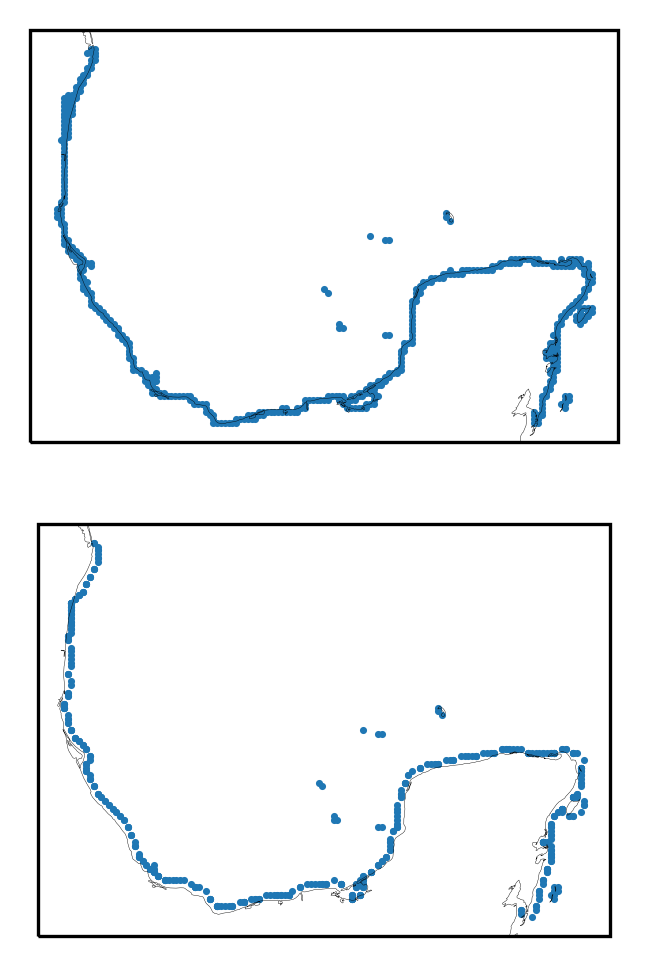

In [22]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(2,1,1,aspect='equal', projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(2,1,2,aspect='equal', projection=ccrs.PlateCarree())

i = 28

ax1.scatter(plon[region_paths_list[i][:,0]], plat[region_paths_list[i][:,1]], s=0.5, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

ax2.scatter(plon[ocean_paths_list[i][:,0]], plat[ocean_paths_list[i][:,1]], s=0.5, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

# Generate particles uniformly for each country around the coastline

In [23]:
def number_of_particles(tons):
    """
    Convert tons of plastic per year to a number of particles
    according to a predefined ranges and base number.
    
    """
    ranges = np.array([0, 1, 10, 100, 1000, 10000, 100000])
    base_nb_particle = 2
    exp = ranges.searchsorted(tons, 'right') - 1 # consider any amount
    
    if exp >= 0:
        return base_nb_particle**exp
    else:
        return 0

In [24]:
np.random.seed(42)

coast_x = []; coast_y = []; coast_w = []; coast_cid = []

for c in range(0, len(caribbean_countries)):
    mass = df.iloc[c]['uniform mpw [ton/year/gridcell]'] * mpw_to_ocean_ratio  # mpw into the ocean [tons]
    n = number_of_particles(mass)
    
    if n:
        for i,j in ocean_paths_list[c]:
            dx = qlon[i+1] - qlon[i]
            dy = qlat[j+1] - qlat[j]

            coast_x.append(qlon[i] + np.random.random_sample(n) * dx)
            coast_y.append(qlat[j] + np.random.random_sample(n) * dy)
            particles_mass = mass / 12 * light_particle_ratio # weight of monthly light particles [tons]
            coast_w.append(np.full(n, particles_mass/n))
            coast_cid.append(np.full(n, c, dtype='int'))
            
coast_x = np.hstack(coast_x)
coast_y = np.hstack(coast_y)
coast_w = np.hstack(coast_w)
coast_cid = np.hstack(coast_cid)

In [25]:
np.sum(coast_cid == 1)

608

In [26]:
print(f'A total of {len(coast_x)} uniform particles.')

A total of 21278 uniform particles.


In [27]:
print(f'A total of {np.sum(coast_w):0.1f} tons per month.')

A total of 10487.7 tons per month.


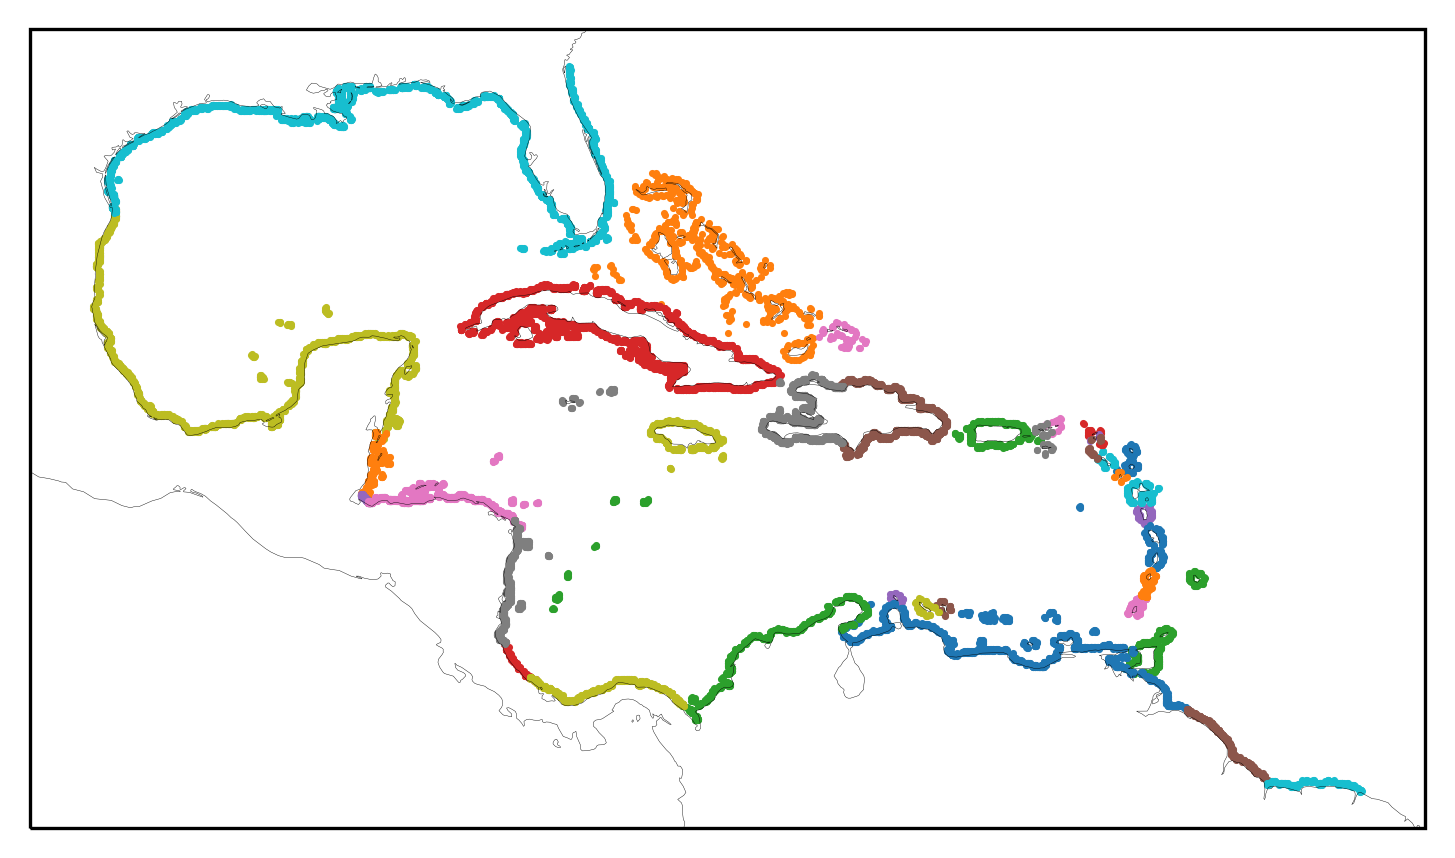

In [28]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

for c in range(0, len(caribbean_countries)):
    r = np.where(coast_cid == c)
    ax.scatter(coast_x[r], coast_y[r], s=0.5, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

# Export csv per country

In [29]:
# coast
df_c = pd.DataFrame({
    'longitude': coast_x,
    'latitude': coast_y,
    'weight [ton]': coast_w,
    'country id': coast_cid,
    })

output_folder = '../data/process/'
df_c.to_csv(join(output_folder, f"coasts_uniform.csv"), index=False)

In [30]:
for i, c in enumerate(caribbean_countries):
    r = np.where(coast_cid == i)

    # coast
    df_c = pd.DataFrame({
        'longitude': coast_x[r],
        'latitude': coast_y[r],
        'weight [ton]': coast_w[r],
        'country id': coast_cid[r],
        })
    
    output_folder = '../data/process/uniform_per_country'
    df_c.to_csv(join(output_folder, f"c{i:02d}_{c.replace(',', '').lower().replace(' ', '-')}.csv"), index=False)